In [10]:
import matplotlib.pyplot as plt
import networkx as nx
from enum import IntEnum
import random
import math
import numpy as np

import math
from queue import PriorityQueue
from random import expovariate, shuffle, uniform, randint
import copy
from matplotlib.backends.qt_compat import QtCore, QtWidgets
from matplotlib.backends.backend_qt5agg import (FigureCanvas, NavigationToolbar2QT as NavigationToolbar)

In [11]:
class NodeType(IntEnum):
    Common=1,
    Bot=2,
    Influencer=3
    
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

class Edge:
    def __init__(self, start, dest, weight):
        self.start = start
        self.dest = dest
        self.weight = weight
class Node:
    def __init__(self,ids,node_type):
        self.id=ids
        self.type=node_type
        self.adj = []
        self.stand = np.random.uniform(-1, 1) #####define the node's political stand left or right, or their tendency in beliveving sth
        self.position_x = np.random.uniform(0, 1)  #######position of x and y define people's abstract distance
        self.position_y = np.random.uniform(0, 1)
        self.message_queue = [] ###use to store information or effect on the node
    def add_adj(self,edge):
        self.adj.append(edge)
    def compute_distance(self,node_b):
        a = np.array([self.position_x, self.position_y])
        b = np.array([node_b.position_x, node_b.position_y])
        return euclidean_distance(a, b)/np.sqrt(2)
    def __str__(self):
        return '{} - deg: {}\n' \
               '\tinterests: {}\n' \
               '\tscore: {}\n' \
               '\tx: {} y: {}'.format(
                self.id, len(self.adj), self.stand,
                self.position_x, self.position_y)
class Network:
    def __init__(self,N_common, N_influencers, N_bots, random_const):
        self.N_common=N_common
        self.N_influencers=N_influencers
        self.N_bots=N_bots
        self.nodes={}
        self.available_id=0
        self.infected_node=None
    def gen_node(self,node_type):
        idx=self.available_id
        node=Node(idx,node_type)
        self.available_id+=1
        self.nodes[node.id]=node
        if node_type==NodeType.Influencer: ####define node property 
            pass
        if node_type==NodeType.Bot: ####define node property 
            pass
        return idx
    def generate_common(self,random_const):
        def add_proximity_edge(idx_a, idx_b, dist, random_const):
            prox = (1 - dist)
            #edge = list(filter(lambda x: x.dest == idx_b, self.nodes[idx_a].adj))
            p = random.uniform(0, 1)
            if dist < random_const and p < 0.3:  ##people need to have close enough distance to be connected and a finite probability
                weight = prox
                self.nodes[idx_a].add_adj(Edge(idx_a, idx_b, weight)) ##normal people's connection are mutual
                self.nodes[idx_b].add_adj(Edge(idx_b, idx_a, weight))
        n = 0
        while n < self.N_common:
            idx = self.gen_node(NodeType.Common)
            for b in self.nodes.keys():
                if idx == b:
                    continue
                phys_dist = self.nodes[idx].compute_distance(self.nodes[b])
                add_proximity_edge(idx, b, phys_dist, random_const)
            n += 1
    def generate_influencers(self, random_const,lim=None):
        def add_proximity_edge(idx_a, idx_b, dist, random_const):
            prox = (1 - dist)
            p = random.uniform(0, 1)
            if dist < random_const and p < 0.6:  ##people need to have close enough distance to be connected
                weight = prox
                self.nodes[idx_a].add_adj(Edge(idx_a, idx_b, weight))###influencers connection is asymmetric
            if dist<random_const and p<0.1:                            
                self.nodes[idx_b].add_adj(Edge(idx_b, idx_a, weight)) ###fewer chance to be affected by common
        
        n = 0
        if lim==None:
            lim=self.N_influencers
        while n < lim:
            idx = self.gen_node(NodeType.Influencer)
            for b in self.nodes.keys():
                if idx == b:
                    continue
                phys_dist = self.nodes[idx].compute_distance(self.nodes[b])
                add_proximity_edge(idx, b, phys_dist, random_const)
            n += 1
    
    def generate_bots(self,random_const,lim=None):
        n=0
        if lim==None:
            lim=self.N_bots
        while n < lim:
            idx = self.gen_node(NodeType.Bot)
            self.nodes[idx].stand = np.random.choice([-1,1])  ###now assume bots are fully biased
            for b in self.nodes.keys():
                if self.nodes[b].type == NodeType.Bot:
                    continue
                p = random.uniform(0, 1)
                if p < 0.02:
                    weight = 0.1
                    self.nodes[idx].add_adj(Edge(idx, b, weight)) ####the bot only affects others
                    #self.nodes[idx].add_adj(Edge(b, idx, weight))
            n += 1
        

In [12]:
class Simulator:
    def __init__(self, N_common, N_influencers, N_bots, random_const,
                 engagement_news=None):

        self.N_common = N_common
        self.N_influencers = N_influencers
        self.N_bots = N_bots

        self.random_const = random_const

        self.engagement_news = engagement_news
        self.network = Network(N_common=N_common, N_influencers=N_influencers, N_bots=N_bots,
                               random_const=random_const)

        self.network.generate_common(self.random_const)
        self.N = len(self.network.nodes)
        self.sim_network = None
    def add_influencers(self, n=None):
        if n is None:
            n = self.N_influencers
        self.network.generate_influencers(self.random_const, n)
        self.N = len(self.network.nodes)
    def add_bots(self, n=None):
        if n is None:
            n = self.N_bots
        self.network.generate_bots(n)
        self.N = len(self.network.nodes)
    
    def run_simulation(self):

        self.n_sim_results = None
        self.sim_time = int(self.sim_time_ui.text())
        self.engagement_news = float(self.engagement_news_ui.text())
        self.simulator.engagement_news = partial(self.calc_engagement, initial_val=self.engagement_news,max_time=self.sim_time)
        print(self.sim_time)

        self.sim_results = self.simulator.simulate(self.sim_time, SIR=self.SIR,
                                                   weighted=self.weighted)
        self.progress_bar.setValue(0)
        for i, net in enumerate(self.sim_results):
            #self.draw_simulation_network(net[1])
            self.progress_bar.setValue(int((i + 1) / len(self.sim_results) * 100))
    def run_n_simulations(self):
        self.sim_results = None
        self.sim_time = int(self.sim_time_ui.text())
        self.engagement_news = float(self.engagement_news_ui.text())
        self.simulator.engagement_news = partial(self.calc_engagement, initial_val=self.engagement_news,max_time=self.sim_time)
        self.progress_bar.setValue(0)
        self.n_sim_results = []
        n_nodes = len(self.network.nodes)
        for n in range(n_nodes):
            for i in range(n_sim):
                self.n_sim_results.append(self.simulator.simulate(self.sim_time, SIR=self.SIR, weighted=self.weighted))
            self.progress_bar.setValue(int((n + 1) / n_nodes * 100))

In [13]:
#####now the network is wrapped inside Simulator class
n_influ=4
n_comm=100
n_bots=4
random_const=0.2
simu=Simulator(n_comm,n_influ,n_bots,random_const)
simu.add_influencers()
simu.add_bots()
network=simu.network

In [15]:
from matplotlib.backends.qt_compat import QtCore, QtWidgets
from matplotlib.backends.backend_qt5agg import (FigureCanvas, NavigationToolbar2QT as NavigationToolbar)
figure = plt.figure()
network_canvas = FigureCanvas(figure)
node_color = {
        NodeType.Common: "skyblue",
        NodeType.Influencer: "red",
        NodeType.Bot: "plum"
    }

<Figure size 864x576 with 0 Axes>

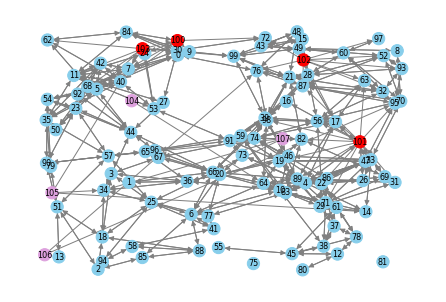

In [16]:
        figure.clf()
        G = nx.DiGraph()
        pos = {}
        color_map = []
        for n, node in network.nodes.items():
            G.add_node(n)
            pos[n] = [node.position_x, node.position_y]
            color_map.append(node_color[node.type])

        edge_labels = []
        for a, node in network.nodes.items():
            for b in node.adj:
                G.add_edge(a, b.dest)
                edge_labels.append(b)

        plt.figure(figure.number)
        nx.draw(G, pos=pos, with_labels=True, font_size=8, node_size=150, node_color=color_map, edge_color="grey")

        #edges_artists = figure.get_axes()[0].patches

In [14]:
#####test branch